In [33]:
# Make sure we can import EMQST_lib from parent directory
import sys
from pathlib import Path

# Go two levels up from current working directory
PROJECT_ROOT = Path.cwd().resolve().parents[1]   # <- one up (your earlier case)


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Using project root:", PROJECT_ROOT)

# Notebook is in project-root/Multiplexed_qubit_readout_results/
# -> project root is the parent of the current working dir
PROJECT_ROOT = Path.cwd().resolve().parent


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import numpy as np 
from datetime import datetime
import os
import uuid
import glob
from EMQST_lib import adaptive_functions as ad
from EMQST_lib.qst import QST  
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import support_functions as sf
from EMQST_lib.povm import POVM
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from EMQST_lib.visualization import power_law
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.autolayout"] = True
cmap        = colormaps['Dark2']
box_props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
%load_ext autoreload
%autoreload 2

Using project root: /workspaces/REMQST
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess
Preprocess data into mean arrays that are saved in same folder.

In [34]:
adaptive_inf_con = []
nonadaptive_inf_con = []
uncertainty_ada_con = []
uncertainty_nonada_con = []
# 
load_path = 'adaptive_results/qdt' #two_qubit_longtest'
glob_path = os.path.join(load_path, '*.npy')
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(load_path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        setting_array = np.load(f, allow_pickle=True)
    adaptive_inf_con.append(infidelity_dict['adaptive_infidelity_container'])
    nonadaptive_inf_con.append(infidelity_dict['nonadaptive_infidelity_container'])
    uncertainty_ada_con.append(infidelity_dict['adaptive_uncertainty_container'])
    uncertainty_nonada_con.append(infidelity_dict['nonadaptive_uncertainty_container'])
noise_strengths = setting_array[0]['noise_strengths']

print(noise_strengths)


mean_ada   = np.mean(adaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)
mean_nonade  = np.mean(nonadaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)
mean_ada_uncertainty   = np.mean(uncertainty_ada_con, axis=(0,2))   # (n_strenghts, n_points,)
mean_nonade_uncertainty  = np.mean(uncertainty_nonada_con, axis=(0,2))   # (n_strenghts, n_points,)
np.save(f'{load_path}/noise_strengths.npy', noise_strengths)
np.save(f'{load_path}/mean_ada.npy', mean_ada)
np.save(f'{load_path}/mean_nonade.npy', mean_nonade)
np.save(f'{load_path}/mean_ada_uncertainty.npy', mean_ada_uncertainty)
np.save(f'{load_path}/mean_nonade_uncertainty.npy', mean_nonade_uncertainty)

Found 1 folders
Folder 0: adaptive_results/qdt/2025-11-12_21-48-57_73d7b76f-2fb1-4223-b35a-3ae609a6ad28
0.15


## Sketch non-adaptive noise

Found 5 folders
Folder 0: adaptive_results/nonadaptive_sketch/2025-10-24_15-56-06_c2cbdb07-1f6e-44be-81ea-9d18292896a0
Folder 1: adaptive_results/nonadaptive_sketch/2025-10-24_15-56-57_7536e345-ce4a-4dbe-9564-3e71fd7dc7f1


KeyboardInterrupt: 

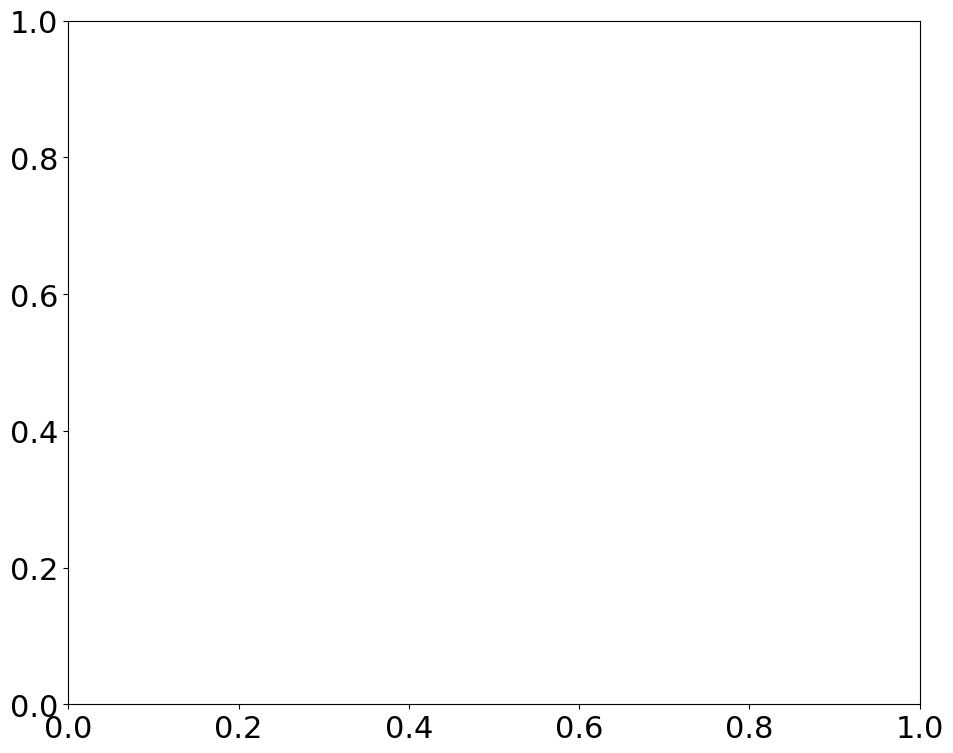

In [17]:

fig, axes = plt.subplots(1, 1, figsize=(10, 8))

#  qubit plot
path = 'adaptive_results/nonadaptive_sketch'
glob_path = os.path.join(path, '*.npy')

unmitigated_container = []
nonadaptive_container = []
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        setting_array = np.load(f, allow_pickle=True)
    unmitigated_container.append(infidelity_dict['infidelity_container_unmitigated'])
    nonadaptive_container.append(infidelity_dict['nonadaptive_infidelity_container'])
noise_strengths = setting_array[0]['noise_strengths']
print(noise_strengths)
# Expect shape: (n_sheets, n_strengths, n_averages, n_points)
mean_unmitigated   = np.mean(unmitigated_container, axis=(0,2))   # (n_strenghts, n_points,)
mean_nonadaptive  = np.mean(nonadaptive_container, axis=(0,2))   # (n_strenghts, n_points,)

# X-axes (allow different lengths just in case)
x   = np.arange(np.shape(mean_unmitigated)[-1])

cutoff  = 1

upper_cutoff = 10000
# --- color map keyed by noise strength ---
color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(noise_strengths)}

# --- styles ---
linestyles  = {'Mitigated': '-', 'Unmitigated': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(noise_strengths):
    color = color_map_one_qubit[p]
    # Mitigated (solid)
    axes.plot(
        x[cutoff:upper_cutoff], mean_nonadaptive[i, cutoff:upper_cutoff],
        linestyle=linestyles['Mitigated'],
        color=color, linewidth=lw_ada
    )

    # Plot unmitigated
    line_un, = axes.plot(
        x[cutoff:upper_cutoff], mean_unmitigated[i, cutoff:upper_cutoff],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_un.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale



# axes formatting
axes.set_xlabel('Number of measurements')
axes.set_ylabel('Mean Infidelity')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(cutoff, upper_cutoff+3)
axes.grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in noise_strengths]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['Unmitigated'],     label='Unmitigated'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['Mitigated'], label='Mitigated')
]

leg1 = axes.legend(handles=one_qubit_color_handles, title='Noise strength', loc='lower left', frameon=True)
axes.add_artist(leg1)  # keep first legend when adding the second
axes.legend(handles=style_handles, loc='upper right', frameon=True)


import numpy as np
from matplotlib.patches import FancyArrowPatch

# --- Helper A: Variance-shift arrow with user-specified start/end (in axes-fraction coords) ---
def add_variance_shift_arrow(ax,
                             start=(0.52, 0.52),   # near center
                             end=(0.75, 0.75),     # center of top-right quadrant
                             label="Variance shift"):
    """
    Draw an arrow and label from `start` to `end` specified in axes-fraction coords (0..1).
    This keeps the arrow looking nice on log scales and independent of data limits.
    """
    # The arrow
    ax.annotate("",
        xy=end, xytext=start,
        xycoords="axes fraction", textcoords="axes fraction",
        arrowprops=dict(arrowstyle="-|>", lw=2, shrinkA=0, shrinkB=0)
    )

    # # Label placed at midpoint, rotated along the arrow direction
    # angle = np.degrees(np.arctan2(end[1]-start[1], end[0]-start[0]))
    # mid = ((start[0] + end[0]) / 2.0, (start[1] + end[1]) / 2.0)
    # ax.text(
    #     mid[0], mid[1], label,
    #     transform=ax.transAxes,
    #     rotation=angle, rotation_mode="anchor",
    #     ha="center", va="center", fontsize=12,
    #     bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.5)
    # )

# --- Helper B: One "Bias" arrow connecting mitigated → unmitigated at given x ---
def add_bias_arrow(ax, x, mean_mitigated, mean_unmitigated,
                   noise_strengths, i_p=None, x_target=5000, label="Bias"):
    """
    Draw a single arrow connecting the mitigated to the unmitigated curve at x_target.
    - x: array of x-values (data coords)
    - mean_mitigated, mean_unmitigated: arrays shaped (n_strengths, n_points)
    - noise_strengths: iterable; choose i_p by index, defaults to the largest noise strength
    - x_target: desired x (uses nearest available)
    """
    # pick which noise-strength curve to annotate
    if i_p is None:
        i_p = int(np.argmax(noise_strengths))  # default: largest p

    # nearest x index
    idx = int(np.argmin(np.abs(x - x_target)))
    x_point = x[idx]

    y_mit = float(mean_mitigated[i_p, idx])
    y_un  = float(mean_unmitigated[i_p, idx])

    # A single arrow from mitigated -> unmitigated
    ax.annotate(
        "", xy=(x_point, y_un), xytext=(x_point, y_mit),
        xycoords="data", textcoords="data",
        arrowprops=dict(arrowstyle="-|>", lw=2)
    )

    # Put the "Bias" label at the midpoint, slightly offset so it doesn't overlap the arrow
    y_mid = 10 ** ((np.log10(y_mit) + np.log10(y_un)) / 2.0)  # nice midpoint for log y
    ax.annotate(
        label,
        xy=(x_point, y_mid), xycoords="data",
        xytext=(-8, 0), textcoords="offset points",
        ha="right", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.0),
    )
    
    
    
axes.annotate(
    "Variance shift",
    xy=(0.47, 0.70),              # position 
    xycoords="axes fraction",     # or "data" if using data coords
    xytext=(0, 0),                # pixel offset from the point
    textcoords="offset points",
    rotation=45,                  # rotation angle 
    rotation_mode="anchor",
    ha="center", va="center",
    fontsize=22,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1.5)
)

# === Use the helpers ===
# Note: in your code, 'mean_nonadaptive' is the mitigated curve.
add_variance_shift_arrow(axes,
                         start=(0.35, 0.6),   # tweak as you like
                         end=(0.55, 0.85),     # roughly center of top-right quadrant
                         label="Variance shift")

add_bias_arrow(axes,
               x=x,
               mean_mitigated=mean_nonadaptive,
               mean_unmitigated=mean_unmitigated,
               noise_strengths=noise_strengths,
               i_p=None,            # or set to a specific index like 0/1/2...
               x_target=5000,
               label="Bias")



n_average_size = np.shape(nonadaptive_container)
#two_qubit_size = np.shape(two_qubit_adaptive_container)

print(f'Number of averages: {n_average_size[0]*n_average_size[2]}')

#axes[1].legend()
fig.savefig("Images/bias-variance-tradeoff.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Full infidelity plot

[0.05]
One qubit p=0.05, adaptive exponent fit: -0.695, non-adaptive exponent fit: -0.535
(4, 99999)
Two qubit p=0.00, adaptive exponent fit: -0.954, non-adaptive exponent fit: -0.567
Two qubit p=0.05, adaptive exponent fit: -0.645, non-adaptive exponent fit: -0.551
Two qubit p=0.15, adaptive exponent fit: -0.585, non-adaptive exponent fit: -0.528
Two qubit p=0.25, adaptive exponent fit: -0.579, non-adaptive exponent fit: -0.531


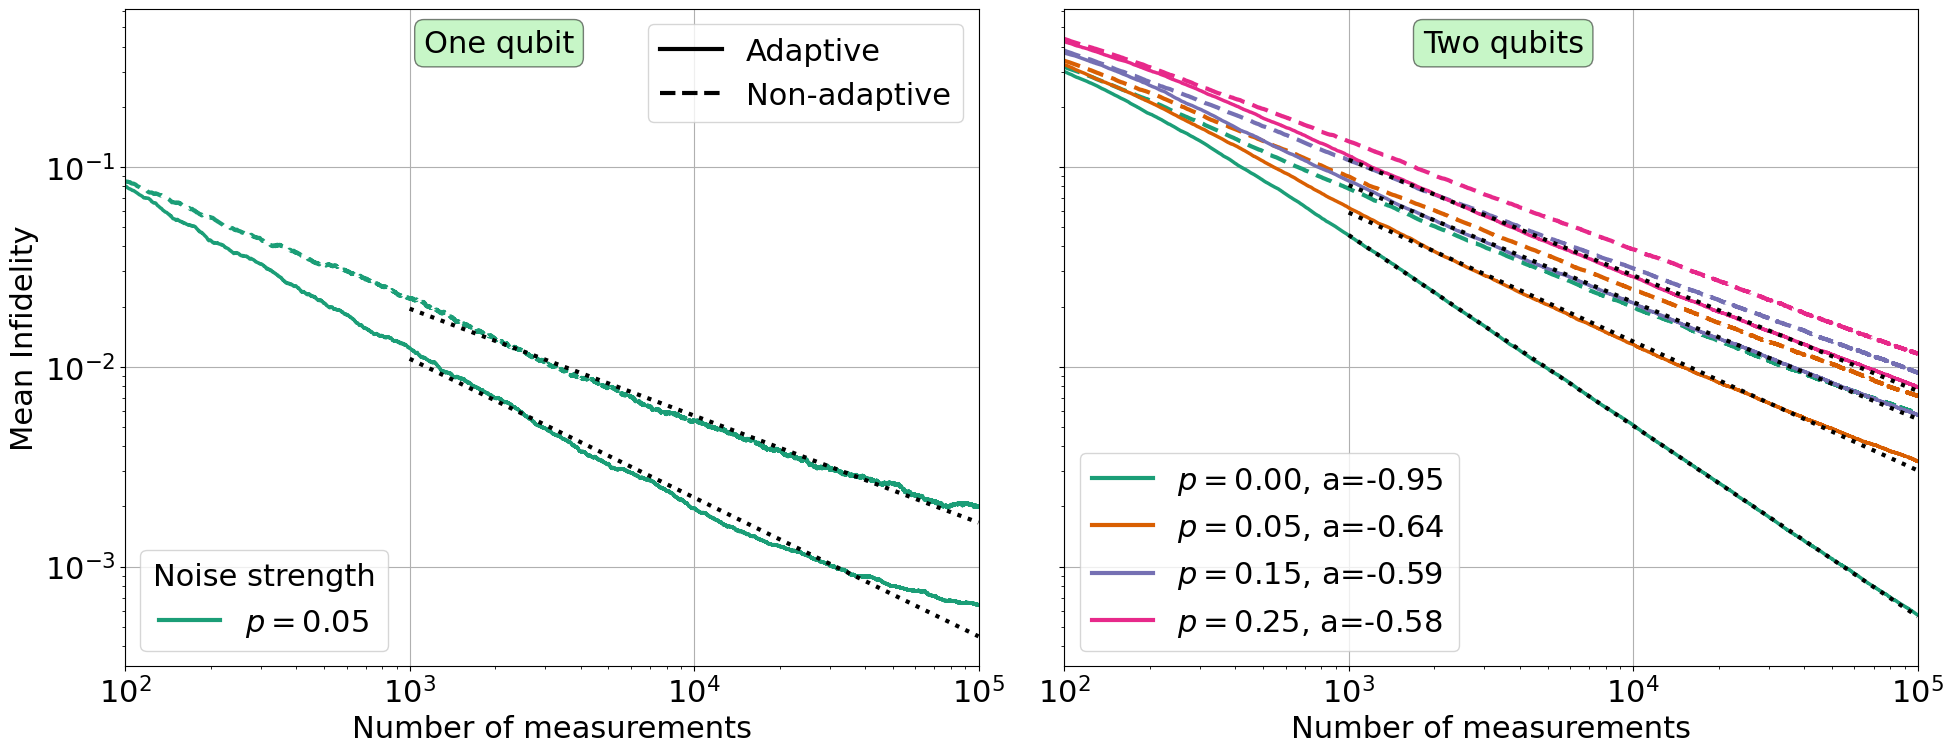

In [28]:

one_qubit_path = 'adaptive_results/qdt'
one_qubit_noise_strengths = np.load(f'{one_qubit_path}/noise_strengths.npy')
mean_one_qubit_ada = np.load(f'{one_qubit_path}/mean_ada.npy')
mean_one_qubit_nonade = np.load(f'{one_qubit_path}/mean_nonade.npy')

print(one_qubit_noise_strengths)
#one_qubit_settings = one_qubit_setting_array[0]
#adaptive_burnin = one_qubit_settings['adaptive_burnin']
#one_qubit_noise_strengths = one_qubit_settings['noise_strengths']

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)


# X-axes (allow different lengths just in case)
x_one_qubit   = np.arange(np.shape(mean_one_qubit_ada)[-1])

adaptive_exponent_fit = []
cutoff     = 100
fitcutoff  = 1000  # fit only after twice the burn-in

# --- color map keyed by noise strength ---

color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}

# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"Adaptive p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_nonade[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # fits (on their own native x after fitcutoff)
    popt_ad,  _ = curve_fit(power_law, x_one_qubit[fitcutoff:],  mean_one_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    popt_non, _ = curve_fit(power_law, x_one_qubit[fitcutoff:], mean_one_qubit_nonade[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    adaptive_exponent_fit.append(popt_ad[1])

    axes[0].plot(x_one_qubit[fitcutoff:],  power_law(x_one_qubit[fitcutoff:],  *popt_ad),
            fit_style, color='k', linewidth=lw_fit)
    axes[0].plot(x_one_qubit[fitcutoff:], power_law(x_one_qubit[fitcutoff:], *popt_non),
           fit_style, color='k', linewidth=lw_fit)
    
    print(f'One qubit p={p:.2f}, adaptive exponent fit: {popt_ad[1]:.3f}, non-adaptive exponent fit: {popt_non[1]:.3f}')

# burn-in marker
#axes[0].axvline(x=adaptive_burnin, color='black', linestyle='--', linewidth=2)
#axes[0].axhline(y=0.01, color='gray', linestyle=':', linewidth=2)
# axes formatting
axes[0].text(0.35, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[0].set_xlabel('Number of measurements')
axes[0].set_ylabel('Mean Infidelity')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(cutoff, 10**5)
axes[0].grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in one_qubit_noise_strengths]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive'),
    #Line2D([0], [0], color='k', lw=3, linestyle=fit_style,                   label='Power-law fit')
]

leg1 = axes[0].legend(handles=one_qubit_color_handles, title='Noise strength', loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
axes[0].legend(handles=style_handles, loc='upper right', frameon=True)



# Two qubit plot
two_qubit_path = 'adaptive_results/two_qubit_100k_new_ada'
# glob_path = os.path.join(two_qubit_path, '*.npy')



mean_two_qubit_ada = np.load(f'{two_qubit_path}/mean_ada.npy')
mean_two_qubit_nonada = np.load(f'{two_qubit_path}/mean_nonade.npy')
two_qubit_noise_strengths = np.load(f'{two_qubit_path}/noise_strengths.npy')

# --- color map keyed by noise strength ---
color_map_two_qubit   = {p: cmap(i) for i, p in enumerate(two_qubit_noise_strengths)}
# Compute means
#mean_two_qubit_ada = np.mean(two_qubit_adaptive_container, axis=(0, 2))
#mean_two_qubit_nonada = np.mean(two_qubit_nonadaptive_container, axis=(0, 2))


print(np.shape(mean_two_qubit_ada))
x_two_qubit = np.arange(np.shape(mean_two_qubit_ada)[-1])
two_qubit_adaptive_exponent_fit = []
# Plotting
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_nonada[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # fits (on their own native x after fitcutoff)
    popt_ad,  _ = curve_fit(power_law, x_two_qubit[fitcutoff:],  mean_two_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    popt_non, _ = curve_fit(power_law, x_two_qubit[fitcutoff:], mean_two_qubit_nonada[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    two_qubit_adaptive_exponent_fit.append(popt_ad[1])
    print(f'Two qubit p={p:.2f}, adaptive exponent fit: {popt_ad[1]:.3f}, non-adaptive exponent fit: {popt_non[1]:.3f}')
    axes[1].plot(x_two_qubit[fitcutoff:],  power_law(x_two_qubit[fitcutoff:],  *popt_ad),
            fit_style, color='k', linewidth=lw_fit)

# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
two_qubit_color_handles = [Line2D([0], [0], color=color_map_two_qubit[p], lw=3, label=rf'$p={p:.2f}$, a={scale:.2f} ')
                 for p, scale in zip(two_qubit_noise_strengths, two_qubit_adaptive_exponent_fit)]


axes[1].legend(handles=two_qubit_color_handles, loc='lower left', frameon=True)
axes[1].text(0.42, 0.97, 'Two qubits', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)

axes[1].set_xlabel('Number of measurements')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(cutoff, x_two_qubit[-1]+3)
axes[1].grid(True, alpha=1)



# one_qubit_size = np.shape(one_qubit_adaptive_inf_con)
# two_qubit_size = np.shape(two_qubit_adaptive_container)
# print(two_qubit_size)
# print(f'Size of one qubit exponents: {one_qubit_size[0]*one_qubit_size[2]}, two qubit exponents: {two_qubit_size[0]*two_qubit_size[2]}')

#axes[1].legend()
fig.savefig("Images/Infidelity_comparison.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()




## Shot threshold

Adaptive counts: 1050, Non-adaptive counts: 1050
Adaptive counts: 1050, Non-adaptive counts: 1050
Adaptive counts: 1050, Non-adaptive counts: 1050
Adaptive counts: 1050, Non-adaptive counts: 1050
Adaptive counts: 1050, Non-adaptive counts: 1050
Adaptive counts: 1050, Non-adaptive counts: 1050


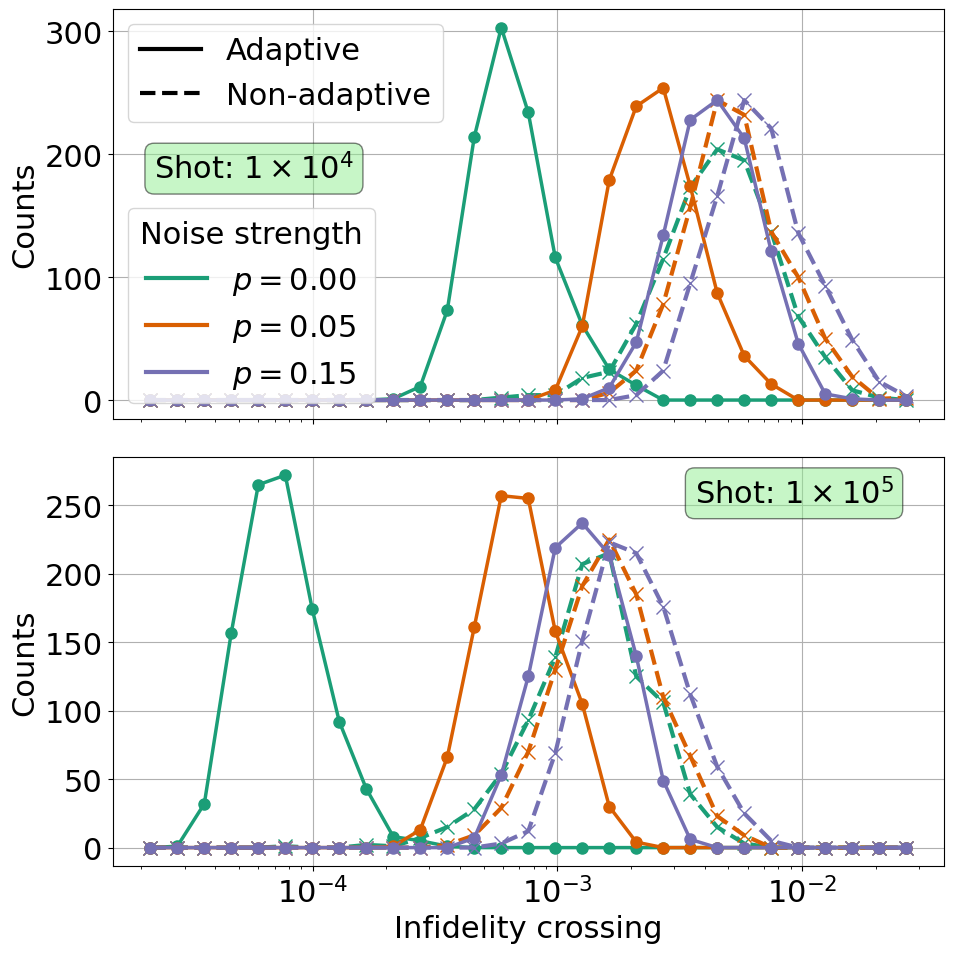

In [4]:
def find_shot_cross_array(shot_value, inf_container):
    # Containers has [#separate_fils, #err_runs, #N_averages, #N_shots ]
    shape = np.shape(inf_container)
    reshaped_container = np.einsum('ijkl->jikl', inf_container)
    combined_container = np.reshape(reshaped_container, (shape[0], -1, shape[-1]))
    #print(np.shape(combined_container))
    full_cross_array = []
    for container in combined_container:
        cross_array = []
        for run in container:
            cross_array.append(run[shot_value])
        full_cross_array.append(cross_array)
    return np.reshape(full_cross_array, (shape[1], -1))


# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
lw_fit      = 3.0
ada_markersize = 8
nonada_markersize = 10
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued


shot_values = [10000,99998]
fig,axes=plt.subplots(2,1,figsize=(10,10),sharex=True)

#print(ada_cross_array)

for i,ax in enumerate(axes):
    shot_value = shot_values[i]
    ada_cross_array = find_shot_cross_array(shot_values[i], one_qubit_adaptive_inf_con)[:-1]
    noada_cross_array = find_shot_cross_array(shot_values[i], one_qubit_nonadaptive_inf_con)[:-1]
    for noise_index in range(len(ada_cross_array)):
        #combined_array = np.concatenate((ada_cross_array, noada_cross_array), axis=0)
        min_value = 1.9e-05 #np.min(ada_cross_array)
        max_value = 0.03#np.max(noada_cross_array)
        #print(min_value, max_value)
        steps = 30
        levels = np.logspace(np.log10(min_value), np.log10(max_value), steps)

        #print(levels)
        # --- if your find_corss_array returns 1-element arrays, make sure rows are scalars ---
        def _row_to_1d_int(arr_row):
            """Safely flatten a possibly ragged row of 1-element arrays into ints."""
            # e.g. arr_row could look like [array([12]), array([7]), ...]
            flat = [np.ravel(x)[0] for x in arr_row]
            return np.asarray(flat)

        # Take the first row from each cross array and coerce to 1D ints
        ada_vals = _row_to_1d_int(ada_cross_array[noise_index])
        noada_vals = _row_to_1d_int(noada_cross_array[noise_index])

        # Use your 'levels' as bin edges
        bin_edges = np.asarray(levels)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #print(bin_centers)
        # Histograms over the provided bins
        ada_counts, _   = np.histogram(ada_vals, bins=bin_edges)
        noada_counts, _ = np.histogram(noada_vals, bins=bin_edges)
        #print(ada_counts)
        print(f'Adaptive counts: {np.sum(ada_counts)}, Non-adaptive counts: {np.sum(noada_counts)}')
        # Plot as curves over the discrete bins

        ax.plot(bin_centers, ada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_ada, marker='o', markersize=ada_markersize, linestyle='-', label=f'Adaptive {shot_value}')
        ax.plot(bin_centers, noada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_nonada, marker='x', markersize=nonada_markersize, linestyle='--', label=f'Non-adaptive {shot_value}')
        ax.set_xscale('log')
        ax.set_ylabel('Counts')
        ax.grid(True, alpha=0.3)




# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths[:-1])]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]

leg1 = axes[0].legend(handles=color_handles, title='Noise strength',loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
 # keep first legend when adding the second
axes[0].grid(True, alpha=1)
axes[1].grid(True, alpha=1)
axes[0].legend(handles=style_handles, loc='upper left', frameon=True)

axes[1].set_xlabel('Infidelity crossing')
# def sci_notation_latex(n, precision=0):
#     # Convert to scientific notation string
#     s = f"{n:.{precision}e}"
#     base, exp = s.split("e")
#     exp = int(exp)
#     return f"{base} \\times 10^{{{exp}}}"
axes[0].text(0.05, 0.65, fr'Shot: $1 \times 10^4$', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].text(0.7, 0.95, fr'Shot: $1 \times 10^5$', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
fig.savefig("Images/Infidelity_at_shot_threshold.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Comparing adaptive to non-adaptive methods

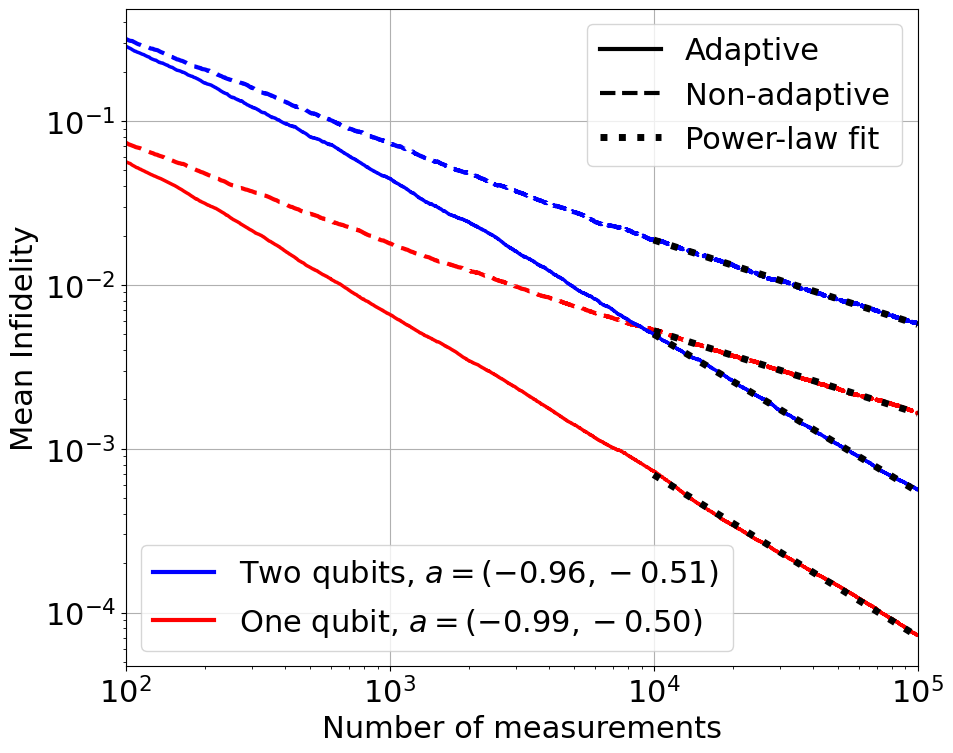

In [5]:
one_qubit_settings = one_qubit_setting_array[0]
adaptive_burnin = one_qubit_settings['adaptive_burnin']
one_qubit_noise_strengths = one_qubit_settings['noise_strengths']



fig, axes = plt.subplots(1, 1, figsize=(10, 8), sharey=True)

# Expect shape: (n_sheets, n_strengths, n_averages, n_points)
mean_one_qubit_ada   = np.mean(one_qubit_adaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)
mean_one_qubit_nonade  = np.mean(one_qubit_nonadaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)

# X-axes (allow different lengths just in case)
x   = np.arange(np.shape(one_qubit_adaptive_inf_con)[-1])
cutoff     = 100
fitcutoff  = 10000  # fit only after twice the burn-in


# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 5.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued



# Plot adaptive (solid)
line_ad, = axes.plot(
    x[cutoff:], mean_one_qubit_ada[0, cutoff:],
    linestyle=linestyles['adaptive'],
    color='red', linewidth=lw_ada,
    label=f"Adaptive"
)

# Plot non-adaptive (dashed) 
line_1non, = axes.plot(
    x[cutoff:], mean_one_qubit_nonade[0, cutoff:],
    linestyle=linestyles['non-adaptive'], color='red', linewidth=lw_nonada
)
line_1non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

# fits (on their own native x after fitcutoff)
popt_1ad,  _ = curve_fit(power_law, x[fitcutoff:],  mean_one_qubit_ada[0,fitcutoff:],  p0=np.array([1.0, -0.5]))
popt_1non, _ = curve_fit(power_law, x[fitcutoff:], mean_one_qubit_nonade[0,fitcutoff:], p0=np.array([1.0, -0.5]))

axes.plot(x_one_qubit[fitcutoff:],  power_law(x_one_qubit[fitcutoff:],  *popt_1ad),
        fit_style, color='k', linewidth=lw_fit)
axes.plot(x_one_qubit[fitcutoff:], power_law(x_one_qubit[fitcutoff:], *popt_1non),
       fit_style, color='k', linewidth=lw_fit)

# Two qubit plot
# two_qubit_path = 'adaptive_results/two_qubit_100k'
# glob_path = os.path.join(two_qubit_path, '*.npy')

# two_qubit_adaptive_container = []
# two_qubit_nonadaptive_container = []
# # Find all folders in subfolder
# folders = [f for f in glob.glob(os.path.join(two_qubit_path, "*")) if os.path.isdir(f)]
# print(f'Found {len(folders)} folders')
# for i, folder in enumerate(folders):
#     print(f'Folder {i}: {folder}')
#     with open(f'{folder}/infidelity_container.npy', 'rb') as f:
#         infidelity_dict = np.load(f, allow_pickle=True).item()
#     with open(f'{folder}/settings.npy', 'rb') as f:    
#         two_qubit_setting_array = np.load(f, allow_pickle=True)
#     two_qubit_adaptive_container.append(infidelity_dict['adaptive_infidelity_container'])
#     two_qubit_nonadaptive_container.append(infidelity_dict['nonadaptive_infidelity_container'])


# Compute means
mean_two_qubit_ada = np.mean(two_qubit_adaptive_container, axis=(0, 2))
mean_two_qubit_nonada = np.mean(two_qubit_nonadaptive_container, axis=(0, 2))

# Plot adaptive (solid)
line_ad, = axes.plot(
    x[cutoff:], mean_two_qubit_ada[0, cutoff:],
    linestyle=linestyles['adaptive'],
    color='blue', linewidth=lw_ada,
    label=f"p="
)

line_2non, = axes.plot(
    x[cutoff:], mean_two_qubit_nonada[0, cutoff:],
    linestyle='--', color='blue', linewidth=lw_nonada
)
line_2non.set_dashes([4,2])  # 8 points on, 4 off — consistent on log scale

# fits (on their own native x after fitcutoff)
popt_2ad,  _ = curve_fit(power_law, x[fitcutoff:],  mean_two_qubit_ada[0,fitcutoff:],  p0=np.array([1.0, -0.5]))
popt_2non, _ = curve_fit(power_law, x[fitcutoff:], mean_two_qubit_nonada[0,fitcutoff:], p0=np.array([1.0, -0.5]))

axes.plot(x_two_qubit[fitcutoff:],  power_law(x_two_qubit[fitcutoff:],  *popt_2ad),
        fit_style, color='k', linewidth=lw_fit)
axes.plot(x_two_qubit[fitcutoff:],  power_law(x_two_qubit[fitcutoff:],  *popt_2non),
        fit_style, color='k', linewidth=lw_fit)

# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---

axes.set_xlabel('Number of measurements')
axes.set_ylabel('Mean Infidelity')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(cutoff, x_one_qubit[-1]+3)
axes.grid(True, alpha=1)

color_handles = [Line2D([0], [0], color='blue', lw=3, label=rf'Two qubits, $a=({popt_2ad[1]:.2f},{popt_2non[1]:.2f})$ '),
                 Line2D([0], [0], color='red', lw=3, label=rf'One qubit, $a=({popt_1ad[1]:.2f},{popt_1non[1]:.2f})$ ')]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive'),
    Line2D([0], [0], color='k', lw=5, linestyle=fit_style,                   label='Power-law fit')
]


leg1 = axes.legend(handles=color_handles, loc='lower left', frameon=True)
axes.add_artist(leg1)  # keep first legend when adding the second
axes.legend(handles=style_handles, loc='upper right', frameon=True)
fig.savefig("Images/adaptive_vs_non_adaptive.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

## Adaptive relative improvment factor

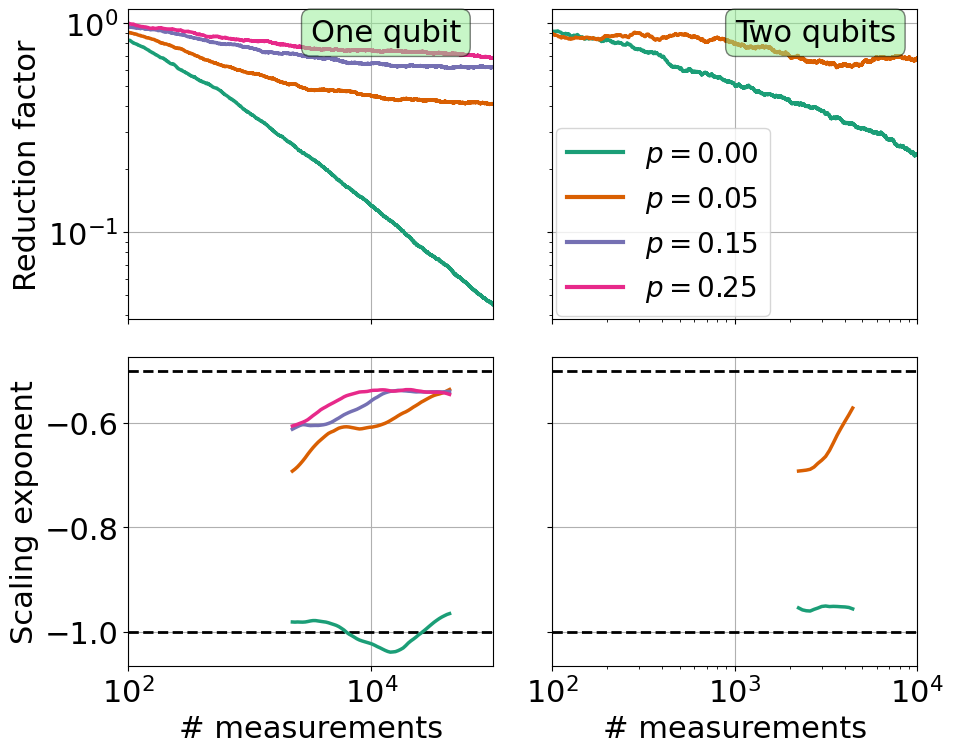

In [4]:
#one_qubit_100k_large_noise_large_bank
one_qubit_path = 'adaptive_results/random_one_qubit'
one_qubit_noise_strengths = np.load(f'{one_qubit_path}/noise_strengths.npy')
mean_one_qubit_ada = np.load(f'{one_qubit_path}/mean_ada.npy')
mean_one_qubit_nonade = np.load(f'{one_qubit_path}/mean_nonade.npy')


fig, axes4 = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 8))
axes = axes4.flatten()

# X-axes (allow different lengths just in case)
x_one_qubit   = np.arange(np.shape(mean_one_qubit_ada)[-1])

adaptive_exponent_fit = []
cutoff     = 100
fitcutoff  = 1000  # fit only after twice the burn-in

# --- color map keyed by noise strength ---

color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}

# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]

    # Plot adaptive (solid)
    axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_ada[i, cutoff:]/mean_one_qubit_nonade[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"Adaptive p={p:.2f}"
    )

axes[0].text(0.50, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
#axes[0].set_xlabel('Number of measurements')
axes[0].set_ylabel('Reduction factor')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(cutoff, x_one_qubit[-1]+3)
axes[0].grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in one_qubit_noise_strengths]

axes[1].legend(handles=one_qubit_color_handles, loc=(0.01, 0.01), frameon=True, fontsize=20)


# Two qubit plot
two_qubit_path = 'adaptive_results/random_test_two_qubit'
# glob_path = os.path.join(two_qubit_path, '*.npy')

mean_two_qubit_ada = np.load(f'{two_qubit_path}/mean_ada.npy')
mean_two_qubit_nonada = np.load(f'{two_qubit_path}/mean_nonade.npy')
two_qubit_noise_strengths = np.load(f'{two_qubit_path}/noise_strengths.npy')

# --- color map keyed by noise strength ---
color_map_two_qubit   = {p: cmap(i) for i, p in enumerate(two_qubit_noise_strengths)}
x_two_qubit = np.arange(np.shape(mean_two_qubit_ada)[-1])
two_qubit_adaptive_exponent_fit = []
# Plotting
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]

    # Plot adaptive (solid)
    axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_ada[i, cutoff:]/mean_two_qubit_nonada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"p={p:.2f}"
    )
# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
two_qubit_color_handles = [Line2D([0], [0], color=color_map_two_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in two_qubit_noise_strengths]


#axes[1].legend(handles=two_qubit_color_handles, loc='lower left', frameon=True)
axes[1].text(0.5, 0.97, 'Two qubits', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)

#axes[1].set_xlabel('Number of measurements')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(cutoff, x_two_qubit[-1]+3)
axes[1].grid(True, alpha=1)


# Hyperparameters (full-span, log windows)
SPAN = 5         # each fit covers [x, SPAN*x]
STEP_FACTOR = 1.05  # multiplicative increase in next window fit
start_one = max(fitcutoff, cutoff)
start_two = max(fitcutoff, cutoff)

# Plotting some guiding lines
axes[2].axhline(y=-0.5, color='black', linestyle='--', linewidth=2)
axes[2].axhline(y=-1.0, color='black', linestyle='--', linewidth=2)
axes[3].axhline(y=-0.5, color='black', linestyle='--', linewidth=2)
axes[3].axhline(y=-1.0, color='black', linestyle='--', linewidth=2)


# -------- One qubit (adaptive) --------
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]
    x_ada, a_ada = vis.exponent_series_curvefit_logspan(
        mean_one_qubit_ada[i], x_one_qubit,
        span=SPAN, step_factor=STEP_FACTOR, start_idx=start_one,
        include_final_window=True
    )
    if a_ada.size:
        axes[2].plot(x_ada, a_ada, linestyles['adaptive'], lw=lw_ada, color=color, label=rf'$p={p:.2f}$ (ada)')

axes[2].set_xlabel('# measurements')
axes[2].set_ylabel('Scaling exponent')
axes[2].set_xscale('log')
axes[2].grid(True, alpha=1)
# axes[2].text(0.35, 0.97, 'One qubit', transform=axes[2].transAxes, fontsize=22,
#         verticalalignment='top', bbox=box_props)


# -------- Two qubits (adaptive) --------
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]
    x_ada2, a_ada2 = vis.exponent_series_curvefit_logspan(
        mean_two_qubit_ada[i], x_two_qubit,
        span=SPAN, step_factor=STEP_FACTOR, start_idx=start_two,
        include_final_window=True
    )
    if a_ada2.size:
        axes[3].plot(x_ada2, a_ada2, linestyles['adaptive'], lw=lw_ada, color=color, label=rf'$p={p:.2f}$ (ada)')

axes[3].set_xlabel('# measurements')
axes[3].set_xscale('log')
axes[3].grid(True, alpha=1)
# axes[3].text(0.42, 0.97, 'Two qubits', transform=axes[3].transAxes, fontsize=22,
#         verticalalignment='top', bbox=box_props)




fig.savefig("Images/Infidelity_improvment_factor.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Infidelity threshold

50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025


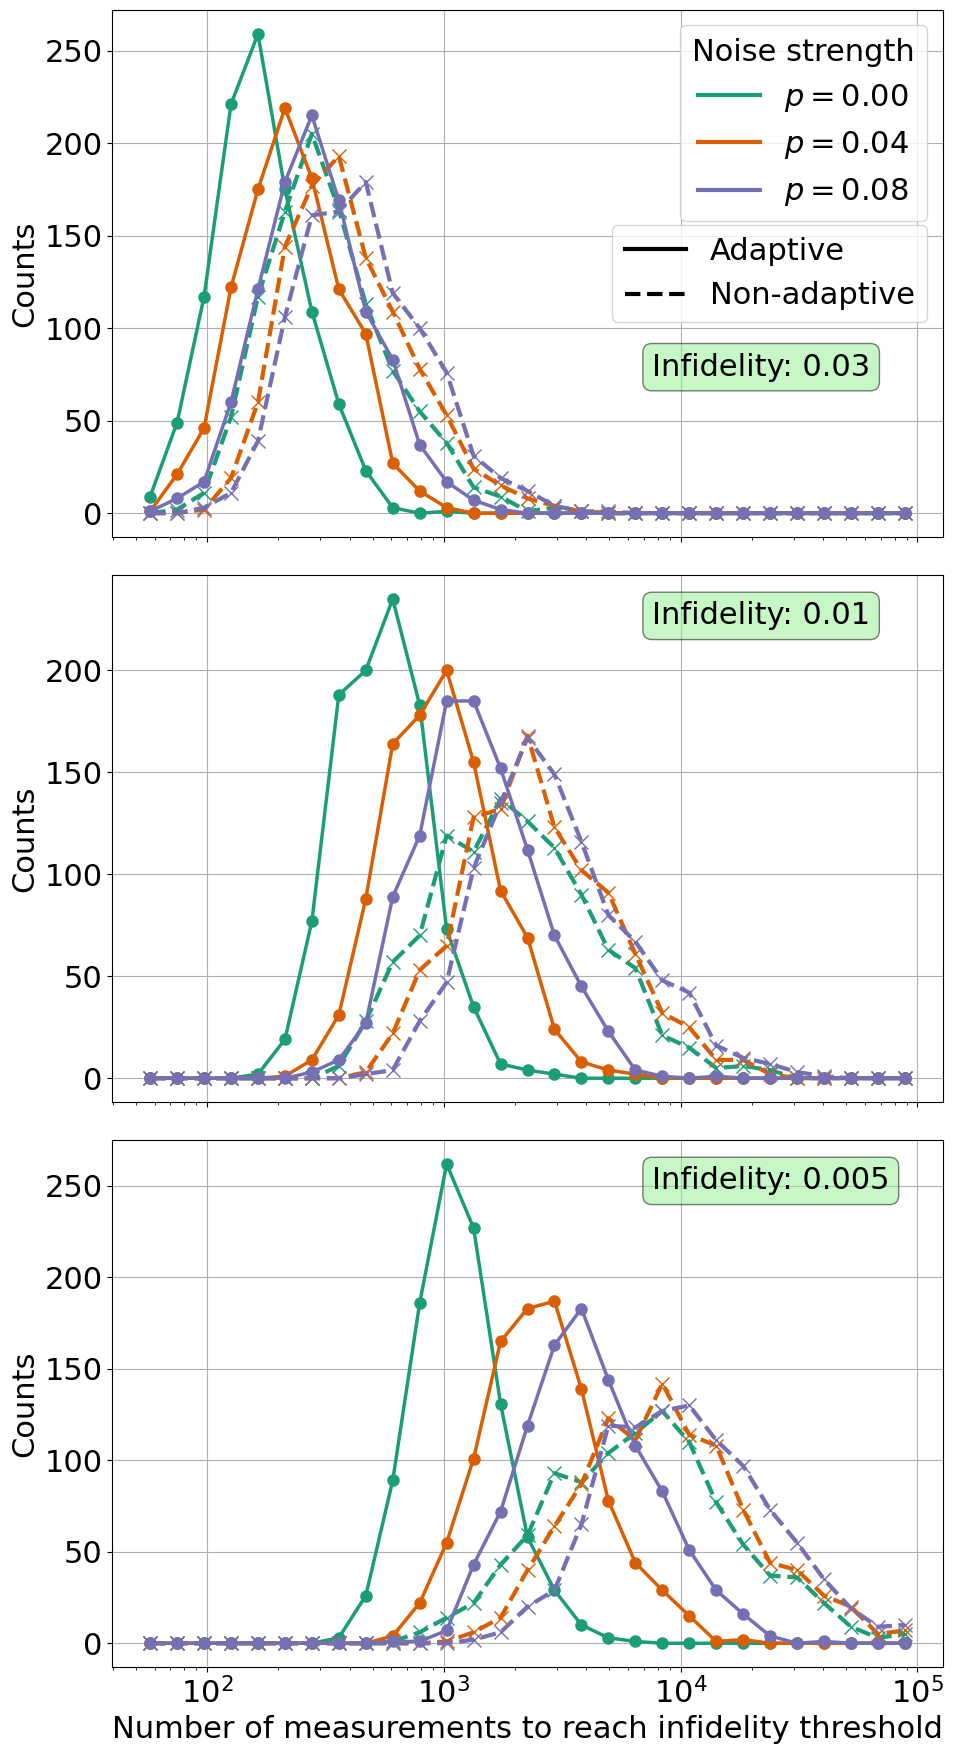

In [ ]:
def find_infidelity_cross_array(threshold_value, inf_container):
    # Containers has [#separate_fils, #err_runs, #N_averages, #N_shots ]
    shape = np.shape(inf_container)
    reshaped_container = np.einsum('ijkl->jikl', inf_container)
    combined_container = np.reshape(reshaped_container, (shape[0], -1, shape[-1]))
    #print(np.shape(combined_container))
    full_cross_array = []
    for container in combined_container:
        cross_array = []
        for run in container:
            arg_crosses = np.argwhere(run < threshold_value)
            if len(arg_crosses) > 0:
                cross_array.append([arg_crosses[0][0]])
            else:   
                cross_array.append([len(run)]) # If it never crosses the threshold, we set it to infinity.
        full_cross_array.append(cross_array)
    return np.reshape(full_cross_array, (shape[1], -1))


# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued
threshold_values = [0.03, 0.01,0.005]


fig,axes = plt.subplots(len(threshold_values),1, figsize=(10,6*len(threshold_values)), sharex=True)
for i, ax in enumerate(axes):
    ada_cross_array = find_infidelity_cross_array(threshold_values[i], one_qubit_adaptive_inf_con)[:-1]
    noada_cross_array = find_infidelity_cross_array(threshold_values[i], one_qubit_nonadaptive_inf_con)[:-1]
    for noise_index in range(len(ada_cross_array)):
        #combined_array = np.concatenate((ada_cross_array, noada_cross_array), axis=0)
        min_value = 50#np.min(ada_cross_array)
        max_value = 10**5#np.max(noada_cross_array)
        print(min_value, max_value)
        steps = 30
        levels = np.logspace(np.log10(min_value), np.log10(max_value), steps)   


        # --- if your find_corss_array returns 1-element arrays, make sure rows are scalars ---
        def _row_to_1d_int(arr_row):
            """Safely flatten a possibly ragged row of 1-element arrays into ints."""
            # e.g. arr_row could look like [array([12]), array([7]), ...]
            flat = [int(np.ravel(x)[0]) for x in arr_row]
            return np.asarray(flat)

        # Take the first row from each cross array and coerce to 1D ints
        ada_vals = _row_to_1d_int(ada_cross_array[noise_index])
        noada_vals = _row_to_1d_int(noada_cross_array[noise_index])

        # Use your 'levels' as bin edges
        bin_edges = np.asarray(levels)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Histograms over the provided bins
        ada_counts, _   = np.histogram(ada_vals, bins=bin_edges)
        noada_counts, _ = np.histogram(noada_vals, bins=bin_edges)

        print(f'Adaptive counts: {np.sum(ada_counts)}, Non-adaptive counts: {np.sum(noada_counts)}')
        # Plot as curves over the discrete bins

        ax.plot(bin_centers, ada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_ada, marker='o', markersize=ada_markersize, linestyle='-', label=f'Adaptive {threshold_values[i]}')
        ax.plot(bin_centers, noada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_nonada, marker='x', markersize=nonada_markersize, linestyle='--', label=f'Non-adaptive {threshold_values[i]}')
        ax.set_xscale('log')
        ax.set_ylabel('Counts')
        ax.grid(True, alpha=1)





# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths[:-1])]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]

leg1 = axes[0].legend(handles=color_handles, title='Noise strength', loc='upper right', frameon=True)
axes[0].add_artist(leg1)  # add the first legend manually
axes[0].legend(handles=style_handles, loc='center right', frameon=True) # keep first legend when adding the second
#plt.legend(handles=style_handles, loc='upper right', frameon=True)

axes[2].set_xlabel('Number of measurements to reach infidelity threshold')


axes[0].text(0.65, 0.35, fr'Infidelity: {threshold_values[0]}', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].text(0.65, 0.95, fr'Infidelity: {threshold_values[1]}', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[2].text(0.65, 0.95, fr'Infidelity: {threshold_values[2]}', transform=axes[2].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
fig.savefig("Images/Shots_to_reach_infidelity.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()



## Uncertainty plotting

[0.   0.05 0.15 0.25]
(4, 1000)
(4, 1000)
[0.   0.05 0.15 0.25]


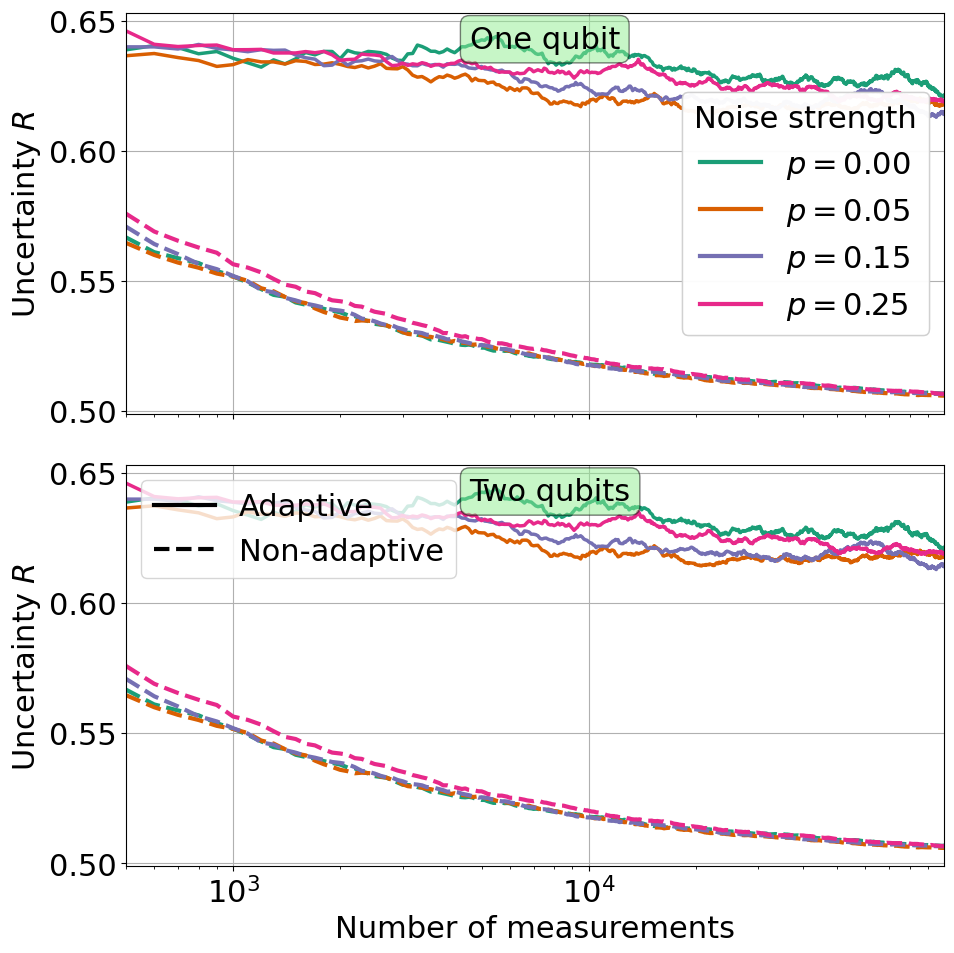

In [7]:
# 'adaptive_results/two_qubit_100k_new_ada'
# 'adaptive_results/one_qubit_100k_large_noise_new_ada'
one_qubit_path = 'adaptive_results/random_one_qubit'

one_qubit_noise_strengths = np.load(f'{one_qubit_path}/noise_strengths.npy')
print(one_qubit_noise_strengths)
mean_one_qubit_ada_uncertainty = np.load(f'{one_qubit_path}/mean_ada_uncertainty.npy')[:,::100] #(n_strengths, n_points)
mean_one_qubit_nonade_uncertainty = np.load(f'{one_qubit_path}/mean_nonade_uncertainty.npy')[:,::100]
xcutoff = 5
print(np.shape(mean_one_qubit_nonade_uncertainty))

x = np.arange(np.shape(mean_one_qubit_ada_uncertainty)[-1])*100
# cutoff     = 100
print(np.shape(mean_one_qubit_ada_uncertainty))
c = ['red', 'blue', 'green', 'orange']
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued




for i, p  in enumerate(one_qubit_noise_strengths):
    axes[0].plot(x[xcutoff:], mean_one_qubit_ada_uncertainty[i,xcutoff:], linestyle='-', color=color_map[p], linewidth=2.5, label='Adaptive')
    axes[0].plot(x[xcutoff:], mean_one_qubit_nonade_uncertainty[i,xcutoff:], linestyle='--', color=color_map[p], linewidth=3.0, label='Non-adaptive')
axes[0].set_xscale('log')

axes[0].text(0.42, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[0].set_ylabel(r'Uncertainty $R$')



two_qubit_path = 'adaptive_results/random_one_qubit'
two_qubit_noise_strengths = np.load(f'{two_qubit_path}/noise_strengths.npy')
mean_two_qubit_ada_uncertainty = np.load(f'{two_qubit_path}/mean_ada_uncertainty.npy')[:,::100] #(n_strengths, n_points)
mean_two_qubit_nonada_uncertainty = np.load(f'{two_qubit_path}/mean_nonade_uncertainty.npy')[:,::100]

color_map   = {p: cmap(i) for i, p in enumerate(two_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued


xcutoff = 5
print(two_qubit_noise_strengths)
x = np.arange(np.shape(mean_two_qubit_ada_uncertainty)[-1])*100
for i, p  in enumerate(two_qubit_noise_strengths):
    axes[1].plot(x[xcutoff:], mean_two_qubit_ada_uncertainty[i,xcutoff:], linestyle='-', color=color_map[p], linewidth=2.5, label='Adaptive')
    axes[1].plot(x[xcutoff:], mean_two_qubit_nonada_uncertainty[i,xcutoff:], linestyle='--', color=color_map[p], linewidth=3.0, label='Non-adaptive')
axes[1].set_xscale('log')


axes[1].text(0.42, 0.97, 'Two qubits', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].set_ylabel(r'Uncertainty $R$')
axes[1].set_xlabel('Number of measurements')
# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths)]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]
leg1 = axes[0].legend(handles=color_handles, title='Noise strength', loc='center right', frameon=True)
axes[0].add_artist(leg1)  # add the first legend manually
axes[1].legend(handles=style_handles, loc='upper left', frameon=True) # keep first legend when adding the second

axes[0].grid(True, alpha=1)
axes[1].grid(True, alpha=1)
axes[1].set_xlim(x[xcutoff], x[-1]+3)

fig.savefig("Images/Uncertainty.pdf", bbox_inches='tight')
plt.tight_layout()

## QDT

[0, 5, 10, 15]
One qubit p=0.00, adaptive exponent fit: -0.589, non-adaptive exponent fit: -0.549
One qubit p=5.00, adaptive exponent fit: -0.589, non-adaptive exponent fit: -0.549
One qubit p=10.00, adaptive exponent fit: -0.589, non-adaptive exponent fit: -0.549
One qubit p=15.00, adaptive exponent fit: -0.589, non-adaptive exponent fit: -0.549


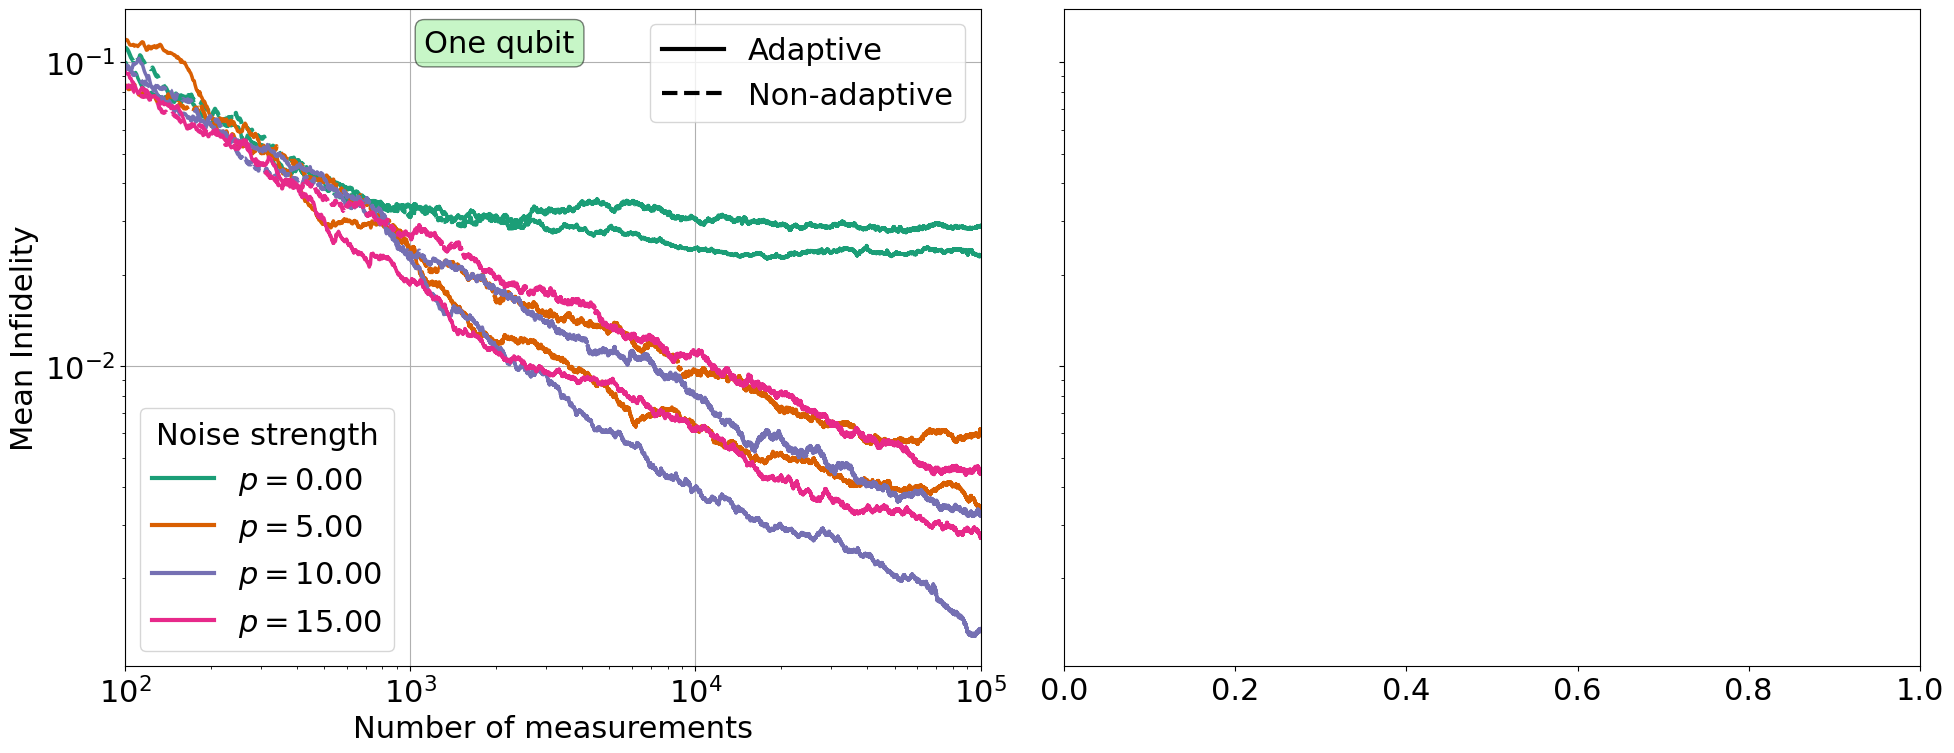

In [36]:

one_qubit_path = 'adaptive_results/qdt'
one_qubit_noise_strengths = [0,5,10,15] #np.load(f'{one_qubit_path}/noise_strengths.npy')
mean_one_qubit_ada = np.load(f'{one_qubit_path}/mean_ada.npy')
mean_one_qubit_nonade = np.load(f'{one_qubit_path}/mean_nonade.npy')

print(one_qubit_noise_strengths)
#one_qubit_settings = one_qubit_setting_array[0]
#adaptive_burnin = one_qubit_settings['adaptive_burnin']
#one_qubit_noise_strengths = one_qubit_settings['noise_strengths']

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)


# X-axes (allow different lengths just in case)
x_one_qubit   = np.arange(np.shape(mean_one_qubit_ada)[-1])

adaptive_exponent_fit = []
cutoff     = 100
fitcutoff  = 1000  # fit only after twice the burn-in

# --- color map keyed by noise strength ---

color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}

# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"Adaptive p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_nonade[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # # fits (on their own native x after fitcutoff)
    # popt_ad,  _ = curve_fit(power_law, x_one_qubit[fitcutoff:],  mean_one_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    # popt_non, _ = curve_fit(power_law, x_one_qubit[fitcutoff:], mean_one_qubit_nonade[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    # adaptive_exponent_fit.append(popt_ad[1])

    # axes[0].plot(x_one_qubit[fitcutoff:],  power_law(x_one_qubit[fitcutoff:],  *popt_ad),
    #         fit_style, color='k', linewidth=lw_fit)
    # axes[0].plot(x_one_qubit[fitcutoff:], power_law(x_one_qubit[fitcutoff:], *popt_non),
    #        fit_style, color='k', linewidth=lw_fit)
    
    print(f'One qubit p={p:.2f}, adaptive exponent fit: {popt_ad[1]:.3f}, non-adaptive exponent fit: {popt_non[1]:.3f}')

# burn-in marker
#axes[0].axvline(x=adaptive_burnin, color='black', linestyle='--', linewidth=2)
#axes[0].axhline(y=0.01, color='gray', linestyle=':', linewidth=2)
# axes formatting
axes[0].text(0.35, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[0].set_xlabel('Number of measurements')
axes[0].set_ylabel('Mean Infidelity')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(cutoff, 10**5)
axes[0].grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in one_qubit_noise_strengths]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive'),
    #Line2D([0], [0], color='k', lw=3, linestyle=fit_style,                   label='Power-law fit')
]

leg1 = axes[0].legend(handles=one_qubit_color_handles, title='Noise strength', loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
axes[0].legend(handles=style_handles, loc='upper right', frameon=True)
